In [22]:
import h5py
import random
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [35]:
all_df = pd.read_csv('./data/train.csv')
all_points = h5py.File('./data/train.h5', 'r')

In [18]:
display(all_df)

,ID,label
0,0,5
1,1,0
2,2,4
3,3,1
4,4,9
...,...,...
49995,49995,5
49996,49996,0
49997,49997,8
49998,49998,4


- training set은 총 5만개 임

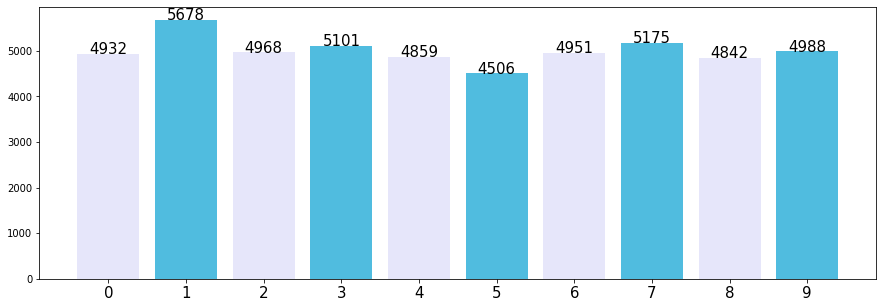

In [19]:
label_cnt = dict(all_df['label'].value_counts().sort_index())
f, axs = plt.subplots(1,1, figsize=(15, 5))

axs.bar(label_cnt.keys(), label_cnt.values(), color=['#e6e6fa' if a%2==0 else '#50bcdf' for a in range(len(label_cnt))])
for k, v in label_cnt.items() :
    axs.annotate('%d'%(v), xy=(k, v), textcoords='data', ha='center',fontsize=15)

axs.set_xticks([i for i in range(0, 10)])
axs.set_xticklabels(label_cnt.keys(), fontsize=15)

plt.show()

# point cloud

In [5]:
from copy import deepcopy
new_df = deepcopy(all_df)

In [6]:
new_df['shape'] = [all_points[str(i)][:].shape for i in range(len(all_df))]

In [7]:
new_df[new_df['label'] == 5]['shape']

0        (25700, 3)
11       (16850, 3)
35       (19600, 3)
47       (19950, 3)
65       (17450, 3)
            ...    
49950    (25400, 3)
49957    (28100, 3)
49991    (28250, 3)
49992    (25900, 3)
49995    (26100, 3)
Name: shape, Length: 4506, dtype: object

- 같은 라벨이라도 shape이 다름
- point 개수가 다르니 글씨의 크기 혹은 point의 밀도가 다를 거라 예상

In [8]:
display(all_points["5"][:])
display(all_points["5"][:].shape)

array([[ 0.15      ,  0.02248134,  0.48498134],
       [ 0.15      ,  0.03498134,  0.48498134],
       [ 0.15      ,  0.04748134,  0.48498134],
       ...,
       [ 0.15      , -0.17751866, -0.39001866],
       [ 0.15      , -0.17751866, -0.40251866],
       [ 0.15      , -0.17751866, -0.41501866]])

(26800, 3)

- x, y, z 값으로 이루어져 있는 Numpy 배열
- normalization 된 좌표값을 가짐

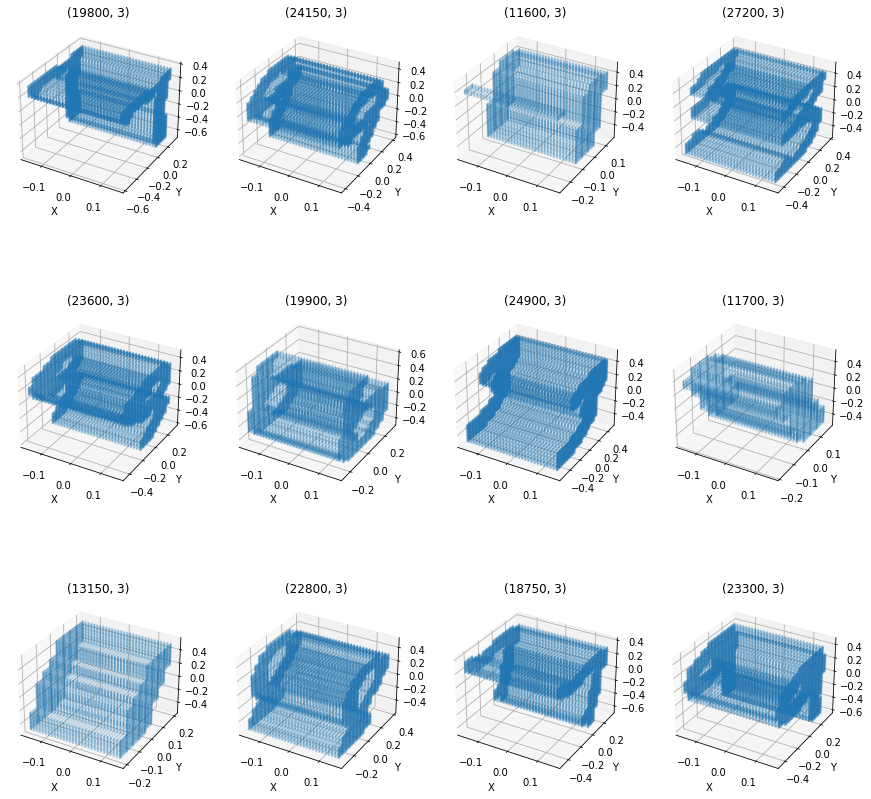

In [156]:
f, axs = plt.subplots(3,4, figsize=(15, 15), subplot_kw={"projection":'3d'})
axs = axs.flatten()
rand_pick = np.random.randint(0,50000,size=12)

for i, pick in enumerate(rand_pick) :
    x = all_points[str(pick)][:,0]
    y = all_points[str(pick)][:,1]
    z = all_points[str(pick)][:,2]

    axs[i].scatter(x,y,z, marker='^', cmap="inferno",s=3, alpha=0.1)
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_title(str(all_points[str(pick)][:].shape))
    axs[i].view_init(elev=30.)

- 손 글씨 형태의 숫자 모양을 하고 있음
- 정면을 바라보고 있음
- 좌표가 듬성듬성 찍혀 있는 데이터도 있음
- 완벽하게 숫자만 써져있는게 아니라 점?? 같은 것도 찍혀있음

### 회전된 데이터

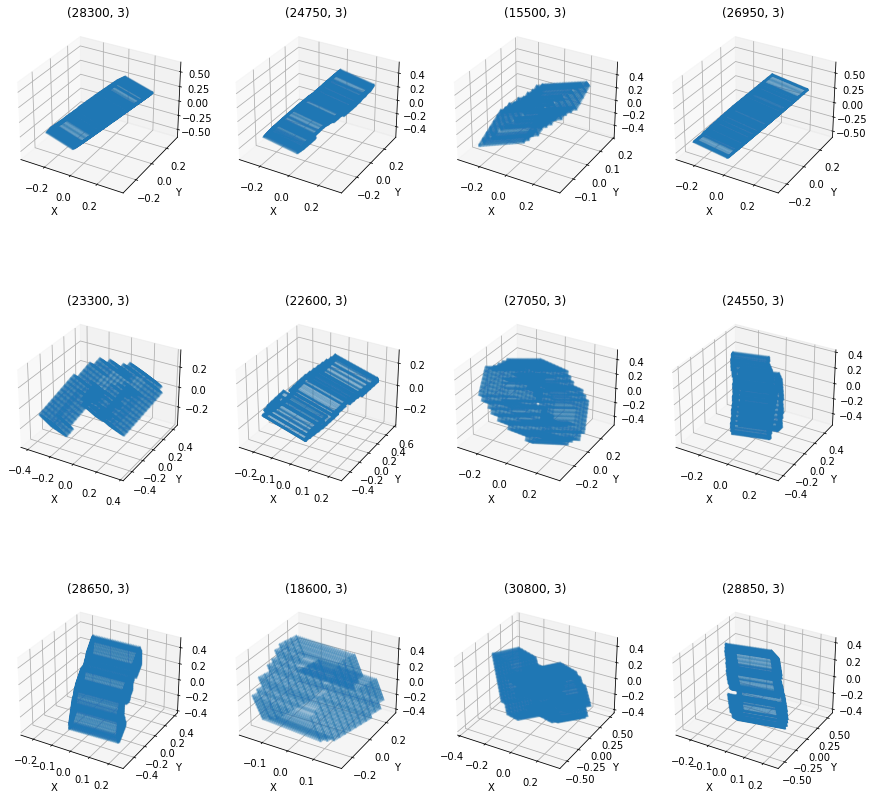

In [56]:
def trans_axis_range(point, axis=[0]) :
    point = np.array(point)
    train_range = np.array([(-0.1579, 0.1579), (-0.7023, 0.6843), (-0.6795, 0.6597)])
    test_range = np.array([(-0.7839, 0.7732), (-0.7591, 0.7707), (-0.7849, 0.7697)])
    # Transform train point range to test point range
    point[:, axis] = point[:, axis] / (np.max(np.abs(train_range[axis])) + 0.1) * (np.min(np.abs(test_range[axis])) - 0.1)

    return point
    
def rand_degree(*rotation_range) :
    assert len([rotation_range]) != 2, 'expected 2 parameters, but given more or less'
    return np.random.uniform(*rotation_range)

def rotate(a, b, c, dots):
    mx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
    my = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
    mz = np.array([[np.cos(c), -np.sin(c), 0], [np.sin(c), np.cos(c), 0], [0, 0, 1]])
    m = np.dot(np.dot(mx,my),mz)
    dots = np.dot(dots, m.T)
    return dots

all_points = h5py.File('./data/train.h5', 'r')
f, axs = plt.subplots(3,4, figsize=(15, 15), subplot_kw={"projection":'3d'})
axs = axs.flatten()
rand_pick = np.random.randint(0,50000,size=12)

for i, pick in enumerate(rand_pick) :
    
    points= trans_axis_range(all_points[str(pick)], axis=[0,1,2])
    
    x_degree = rand_degree(-np.pi/4, np.pi/4)
    y_degree = rand_degree(-np.pi/4, np.pi/4)
    z_degree = rand_degree(-np.pi/6, np.pi/6)

    points = rotate(x_degree, y_degree, z_degree, points)
            
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]

    axs[i].scatter(x,y,z, marker='^', cmap="inferno",s=3, alpha=0.1)
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_title(str(all_points[str(pick)][:].shape))
    axs[i].view_init(elev=30.)

In [23]:
total_size = []
for i in tqdm(range(0, 50000)) :
    total_size.append(all_points[str(i)].shape[0])

total_size = np.array(total_size)
smallest_idx = np.argmin(total_size)
biggest_idx = np.argmax(total_size)

print("가장 많은 point : ",all_points[str(biggest_idx)].shape)
print("가장 적은 point : ",all_points[str(smallest_idx)].shape)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 14745.52it/s]


가장 많은 point :  (38200, 3)
가장 적은 point :  (8600, 3)


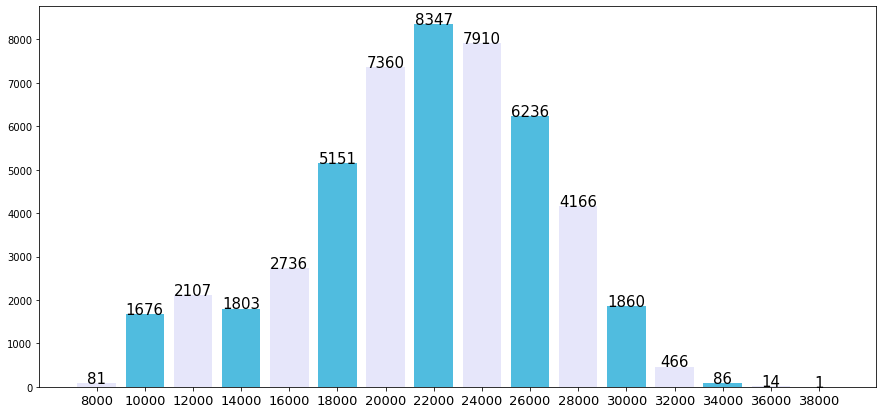

In [24]:
section_list = {k : [] for k in range(8000,39000, 2000)}
_section_num = {str(k) : 0 for k in range(8000,39000, 2000)}

for i, shape in enumerate(total_size) :
    for k in section_list.keys() :
        if k < shape and shape <= k + 2000 :
            section_list[k].append((shape, str(i))) 
            _section_num[str(k)] += 1
            
f, axs = plt.subplots(1,1, figsize=(15, 7))

axs.bar(_section_num.keys(), _section_num.values(), color=['#e6e6fa' if a%2==0 else '#50bcdf' for a in range(len(_section_num))])
for k, v in _section_num.items() :
    axs.annotate('%d'%(v), xy=(k, v), ha='center',fontsize=15)

axs.set_xticks([i for i in _section_num.keys()])
axs.set_xticklabels(_section_num.keys(), fontsize=13)

plt.show()

## Augmentation

In [41]:
[i for i in range(1)]

[0]

In [10]:
from copy import deepcopy
train_points = h5py.File('./data/train.h5', 'r')

In [29]:
def jittering(point, scale_range) :
    point += np.random.uniform(*scale_range, size=point.shape) 
    return point

def scaling(point, scale_range) :
    point *= np.random.uniform(*scale_range)
    return point

def rand_sampling(point) :
    point_num = point.shape[0]

    if point_num >= 20000 :
        sampling_rate=0.6
    else :
        sampling_rate=0.8

    sampling_idx = np.sort(np.random.choice(point_num, int(point_num * sampling_rate) , replace=False))
    point = point[sampling_idx, :]
    return point

In [33]:
test_xrange = (-0.7839, 0.7732)
train_xrange = (-0.1579, 0.1579)

p = np.array(train_points["1"])
display(p, p.shape)

p = rand_sampling(p)

display(p, p.shape)
p[:,0] = p[:, 0] / train_xrange[1] * test_xrange[1]
p = jittering(p,(-0.01, 0.01))
p = scaling(p,(1, 1.02))

# display(p)

array([[ 0.15      ,  0.02270992,  0.52146947],
       [ 0.15      ,  0.03520992,  0.52146947],
       [ 0.15      ,  0.04770992,  0.52146947],
       ...,
       [ 0.15      , -0.02729008, -0.45353053],
       [ 0.15      , -0.02729008, -0.46603053],
       [ 0.15      , -0.02729008, -0.47853053]])

(26200, 3)

array([[ 0.15      ,  0.02270992,  0.52146947],
       [ 0.15      ,  0.02270992,  0.50896947],
       [ 0.15      ,  0.03520992,  0.50896947],
       ...,
       [ 0.15      , -0.02729008, -0.45353053],
       [ 0.15      , -0.02729008, -0.46603053],
       [ 0.15      , -0.02729008, -0.47853053]])

(15720, 3)

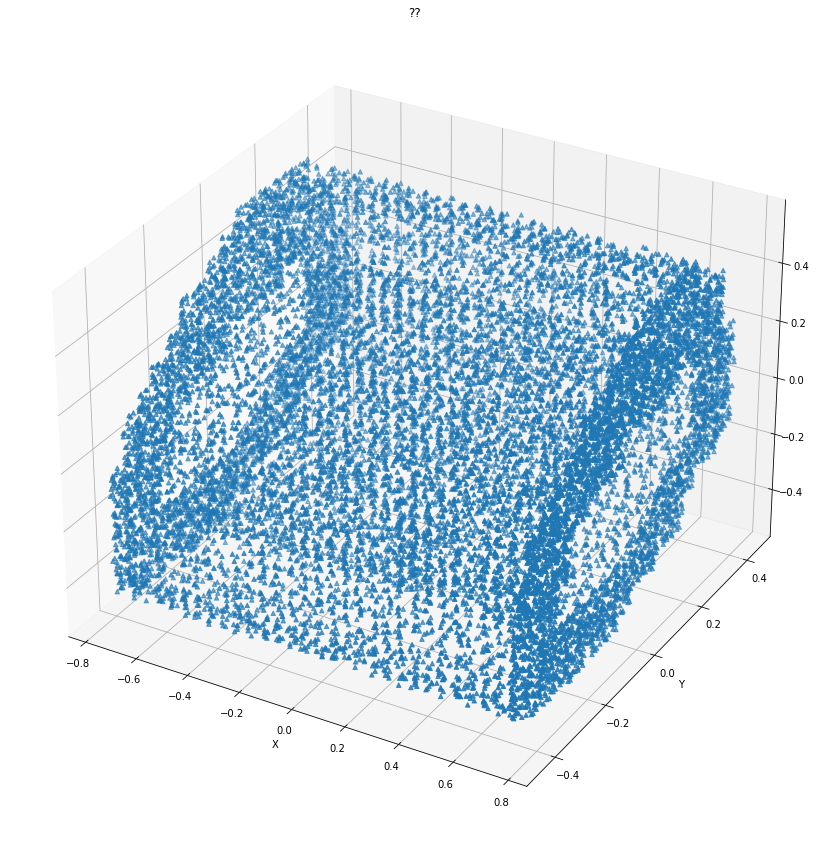

In [32]:
f, axs = plt.subplots(1,1, figsize=(15, 15), subplot_kw={"projection":'3d'})
# axs = axs.flatten()
x = p[:,0]
y = p[:,1]
z = p[:,2]

axs.scatter(x,y,z, marker='^', cmap="inferno")
axs.set_xlabel("X")
axs.set_ylabel("Y")
axs.set_title("??")
axs.view_init(elev=30.)

In [43]:
'''
약 2분30초 소요
'''
# xyzmin = []
# xyzmax = []
# for i in tqdm(range(50000)) :
#     xyzmin.append(np.min(all_points[str(i)], axis=0))
#     xyzmax.append(np.max(all_points[str(i)], axis=0))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:12<00:00, 378.07it/s]


### training set point 범위

In [44]:
# _xyzmin = np.min(np.array(xyzmin), axis=0)
# _xyzmax = np.max(np.array(xyzmax), axis=0)
# print("xyzmin : ", _xyzmin)
# print("xyzmax : ", _xyzmax)
# print("x range : ",_xyzmin[0]," ~ ",_xyzmax[0])
# print("y range : ",_xyzmin[1]," ~ ",_xyzmax[1])
# print("z range : ",_xyzmin[2]," ~ ",_xyzmax[2])

xyzmin :  [-0.15789474 -0.70229885 -0.67952055]
xyzmax :  [0.15789474 0.68434685 0.6597181 ]
x range :  -0.15789473684212604  ~  0.15789473684210517
y range :  -0.7022988505747477  ~  0.6843468468468135
z range :  -0.6795205479452088  ~  0.6597181008902087


In [45]:
# # point cloud range
# xrange = (round(_xyzmin[0], 4), round(_xyzmax[0], 4))
# yrange = (round(_xyzmin[1], 4), round(_xyzmax[1], 4))
# zrange = (round(_xyzmin[2], 4), round(_xyzmax[2], 4))
# vd = 0.4
# vh = 0.2
# vw = 0.2

In [46]:
# print("x range : ",xrange)
# print("y range : ",yrange)
# print("z range : ",zrange)

x range :  (-0.1579, 0.1579)
y range :  (-0.7023, 0.6843)
z range :  (-0.6795, 0.6597)


### Test set point 범위

In [38]:
test_points = h5py.File('./data/test.h5', 'r')
xyzmin = []
xyzmax = []
for i in tqdm(range(50000, 90000)) :
    xyzmin.append(np.min(test_points[str(i)], axis=0))
    xyzmax.append(np.max(test_points[str(i)], axis=0))
    
_xyzmin = np.min(np.array(xyzmin), axis=0)
_xyzmax = np.max(np.array(xyzmax), axis=0)
xrange = (round(_xyzmin[0], 4), round(_xyzmax[0], 4))
yrange = (round(_xyzmin[1], 4), round(_xyzmax[1], 4))
zrange = (round(_xyzmin[2], 4), round(_xyzmax[2], 4))

print("x range : ",xrange)
print("y range : ",yrange)
print("z range : ",zrange)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:43<00:00, 245.05it/s]

x range :  (-0.7839, 0.7732)
y range :  (-0.7591, 0.7707)
z range :  (-0.7849, 0.7697)


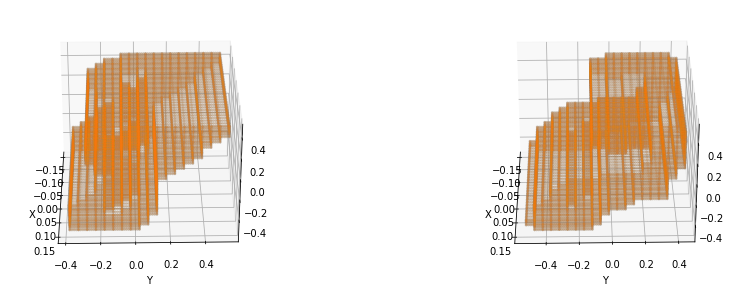

In [142]:
'''
https://jehyunlee.github.io/2021/07/10/Python-DS-80-mpl3d2/
'''
from matplotlib import animation 
f, axs = plt.subplots(1,2, figsize=(15, 5), subplot_kw={"projection":'3d'})

data1 = {"x" : all_points["55"][:,0],
        "y" : all_points["55"][:,1],
        "z" : all_points["55"][:,2]}

data2 = {"x" : all_points["555"][:,0],
        "y" : all_points["555"][:,1],
        "z" : all_points["555"][:,2]}

def init():
    for ax, data in zip(axs, [data1, data2]):
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
    
        ax.scatter(data["x"], data["y"], data["z"], cmap="inferno", s=3, alpha=0.1)
    
    return f,

def animate(i):
    axs[0].view_init(elev=30., azim=i)
    axs[1].view_init(elev=30., azim=i)
    return fig,

# Animate
# anim = animation.FuncAnimation(f, animate, init_func=init, frames=360, interval=20, blit=True)
# Save
# anim.save('mpl3d_scatter.gif', fps=30)

![SegmentLocal](mpl3d_scatter.gif "segment")

In [39]:
test_points = h5py.File('./data/test.h5', 'r')

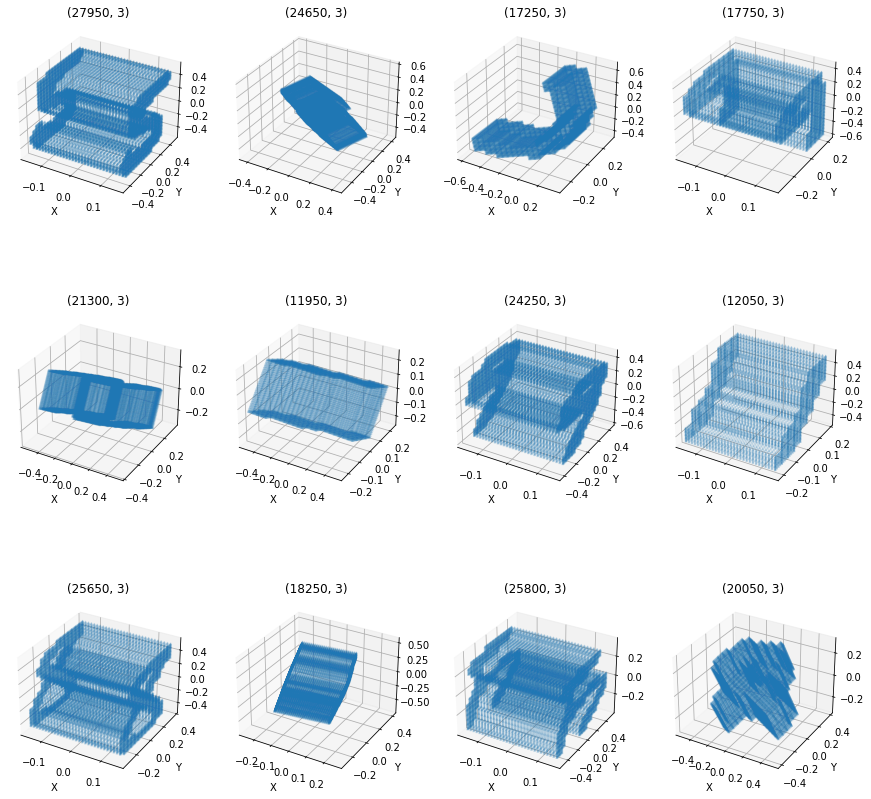

In [60]:
f, axs = plt.subplots(3,4, figsize=(15, 15), subplot_kw={"projection":'3d'})

axs = axs.flatten()
rand_pick = np.random.randint(50000,90000,size=12)

for i, pick in enumerate(rand_pick) :
    x = test_points[str(pick)][:,0]
    y = test_points[str(pick)][:,1]
    z = test_points[str(pick)][:,2]

    axs[i].scatter(x,y,z, marker='^', cmap="inferno",s=3, alpha=0.1)
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_title(str(test_points[str(pick)][:].shape))
    axs[i].view_init(elev=30.)

- test 셋의 경우 회전되어 있는 데이터도 존재
- 6이나 9 같은 경우 상,하로도 뒤집혀 있는지 확인해야할 듯
    - 6과 9가 상하로 뒤집혀 있으면 라벨이 바뀌게됨

In [27]:
test_points = h5py.File('./data/test.h5', 'r')
total_size = []
for i in tqdm(range(50000, 90000)) :
    total_size.append(test_points[str(i)].shape[0])
    

section_list = {k : [] for k in range(8000,38000, 2000)}
section_num = {str(k) : 0 for k in range(8000,38000, 2000)}

for i, shape in enumerate(total_size) :
    for k in section_list.keys() :
        if k < shape and shape <= k + 2000 :
            section_list[k].append((shape, str(50000+i))) 
            section_num[str(k)] += 1

100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:02<00:00, 14151.23it/s]


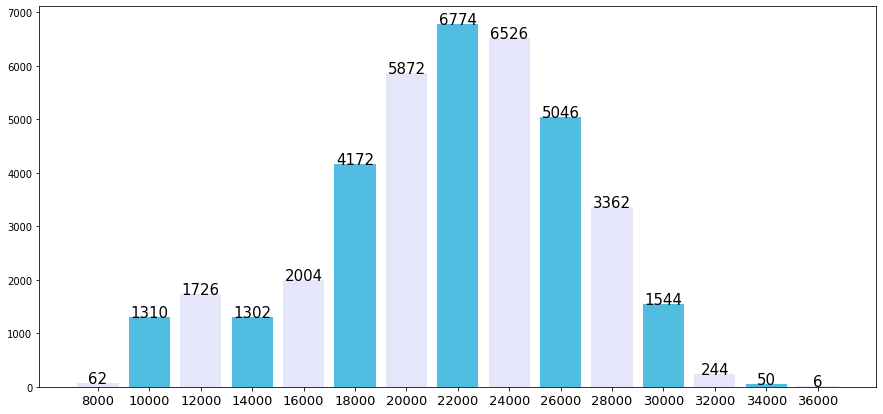

In [28]:
f, axs = plt.subplots(1,1, figsize=(15, 7))

axs.bar(section_num.keys(), section_num.values(), color=['#e6e6fa' if a%2==0 else '#50bcdf' for a in range(len(section_num))])
for k, v in section_num.items() :
    axs.annotate('%d'%(v), xy=(k, v), ha='center',fontsize=15)

axs.set_xticks([i for i in section_num.keys()])
axs.set_xticklabels(section_num.keys(), fontsize=13)

plt.show()